# **GUITAR TUNER**

*   Mykola Liashuha
*   Jose Gonzalez Lopez


## INTRODUCTION
In this work, we present an spectral analysis on 3 different files with the main ofjective to identify the note that was played in each audio. First, all audio files were read and explored by using simple functions such as ploting the audio file or getting the shapes of the elements at hand. Second, with the use of the librosa library we could map elements such as spectrograms or get some interesting features such as the spectral centrum or the spectral bandwidth. Then, each note was identified by applying different procedures and techniques, as not all of them shared the same characteristics. Last, we will discuss the results and wrap up the notebook.

## IMPORTS



In [4]:
#Imports
import numpy as np
import sklearn #Use this library to normalize
import math #For calculations
from scipy.io import wavfile #Read wav files
from matplotlib import pyplot as plt #Plots
from scipy.fft import fft, ifft,fftfreq #Fourier transform


## AUXILIAR FUNCTIONS

In [72]:
'''
Transform all frecuencies into the corresponding notes given in result
'''
def filter(results):
    notes = []
    for r in results:
        if r < 335 and r > 325:
            notes.append("Got E1")
        if r < 251 and r > 240:
            notes.append("Got B2")
        if r < 201 and r > 190:
            notes.append("Got G3")
        if r < 150 and r > 140:
            notes.append("Got D4")
        if r < 115 and r > 105:
            notes.append("Got E6")
        if r < 87 and r > 78:
            notes.append("Got E6")

    return np.unique(notes).tolist()

In [73]:
'''
Normalising x with minmax scale
'''
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

## Data exploration
In the following section we present the basic analysis of each of the 3 audio files

In [74]:
#Read files
sr_1, data_1 = wavfile.read('string_1.wav')
sr_2, data_2 = wavfile.read('string_2.wav')
sr_3, data_3 = wavfile.read('string_3.wav')

In [75]:
#Sample exploration
print(sr_1)
print(sr_2)
print(sr_3)

44100
22050
22050


With this simple prints, we know that the first audio signal has a samplig rate of 44.1 KHZ and the other 2 have 22KHZ

In [76]:
#Data exploration
print(data_1.shape)
print(data_2.shape)
print(data_3.shape)

(237568,)
(117912,)
(124344,)


Not all the audios have the same data. Time to plot them and see the wave signal physically.

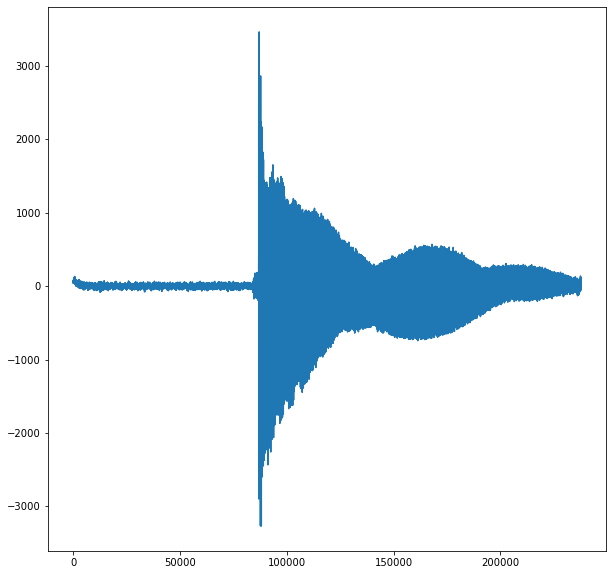

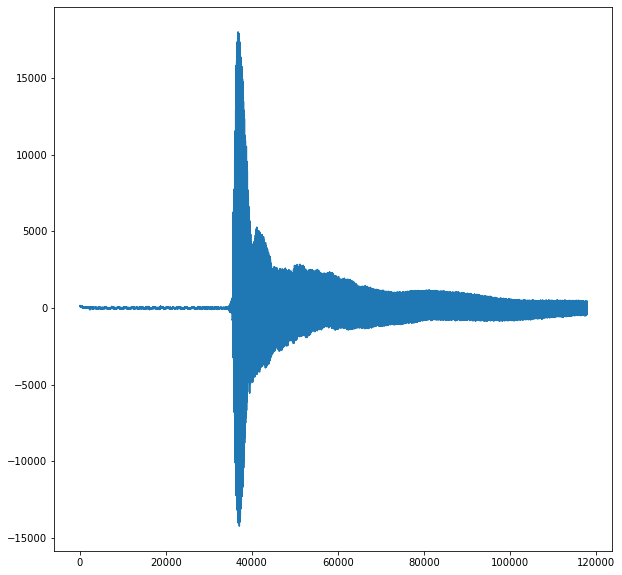

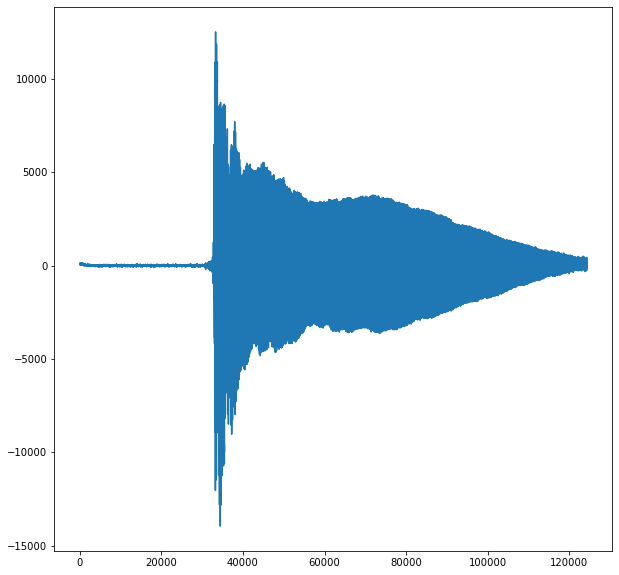

In [77]:
#Plot the string wave
plt.figure(figsize=(10,10))
plt.plot(data_1)
plt.figure(figsize=(10,10))
plt.plot(data_2)
plt.figure(figsize=(10,10))
plt.plot(data_3)

## Note analysis
In this section we will provide the notes of each audio file and justify our findings.

### Fourier transform
Let's get the fourier transform of each file

In [78]:
#Read files
sr_1, data_1 = wavfile.read('string_1.wav')
sr_2, data_2 = wavfile.read('string_2.wav')
sr_3, data_3 = wavfile.read('string_3.wav')

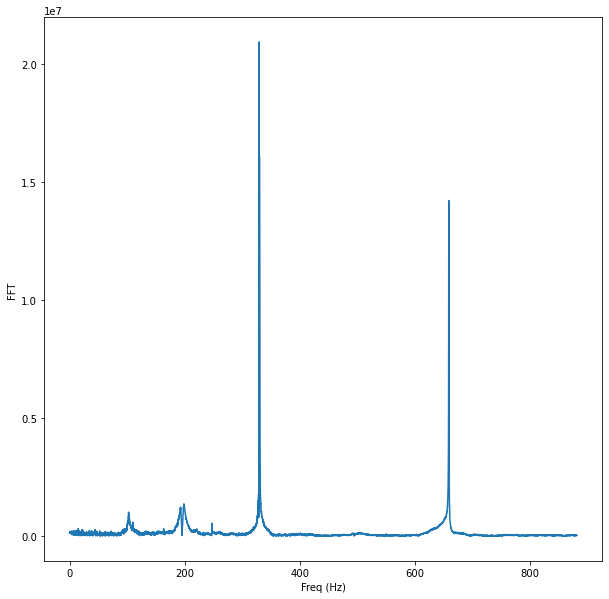

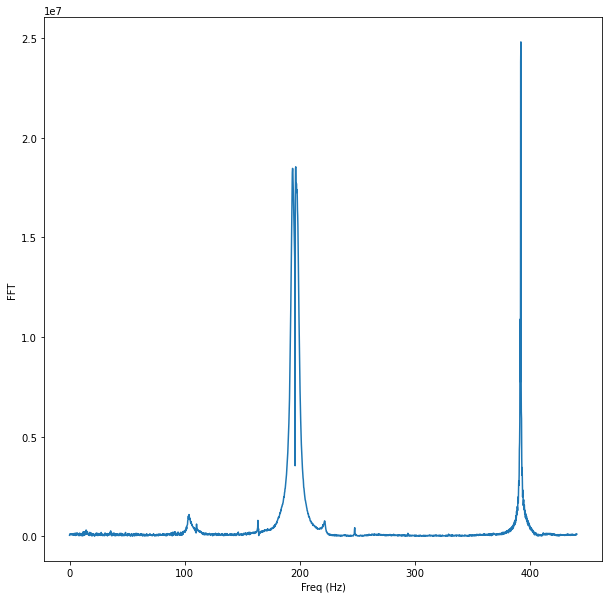

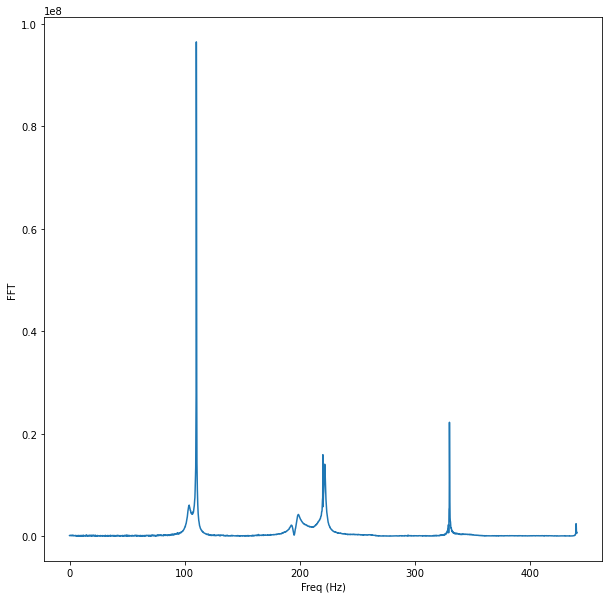

In [160]:
#Prepare to plot fourier transform and get peaks
#Audio 1
N = data_1.shape[0]
# sample spacing
T = 1.0 / sr_1
#Transform
yf_1 = fft(data_1)
xf_1 = fftfreq(N, T)[:N//50]
#And plot
plt.figure(figsize=(10,10))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_1, np.abs(yf_1)[:N//50])
plt.show()

#Audio 2
N = data_2.shape[0]
# sample spacing
T = 1.0 / sr_2
#Transform
yf_2 = fft(data_2)
xf_2 = fftfreq(N, T)[:N//50]
#And plot
plt.figure(figsize=(10,10))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_2, np.abs(yf_2)[:N//50])
plt.show()

#Audio 3
N = data_3.shape[0]
# sample spacing
T = 1.0 / sr_3
#Transform
yf_3 = fft(data_3)
xf_3 = fftfreq(N, T)[:N//50]
#And plot
plt.figure(figsize=(10,10))
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_3, np.abs(yf_3)[:N//50])
plt.show()

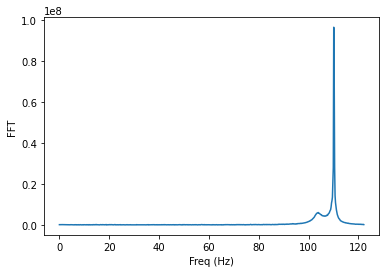

In [161]:
#Audio 3
N = data_3.shape[0]
# sample spacing
T = 1.0 / sr_3
#Transform
yf_3_cp = fft(data_3)
xf_3_cp = fftfreq(N, T)[:N//180]
#And plot
plt.xlabel('Freq (Hz)')
plt.ylabel('FFT')
plt.plot(xf_3_cp, np.abs(yf_3_cp)[:N//180])
plt.show()

Let's do a basic filter to get the highest peaks

In [315]:
'''
Given a range of frecuencies (x) and its values (y), get the ones that are above the threshold.
'''
import scipy.signal
def get_highest_freqs(x, y,threshold=15000000):
    end_range = [i for i, val in enumerate(x) if val > 340][0]
#     print(end_range)
    x = x[:end_range]
    y = np.abs(y)
    y = y[:end_range]
    res = []
    for i in range(len(x)):
        if y[i] > threshold: #This is arbitrary
            res.append(x[i])
    prod = []
    
#     y = scipy.signal.medfilt(y, kernel_size=7)
    for r in res:
        out = get_impulse_range(x, y, r)
        area = 0
        for i in range(out[0], out[1]):
            dif = x[i+1]-x[i]
            tmp = (abs(y[i+1] - y[i])/2)*dif
            area += tmp
#         print(r, xf_1[out[0]], xf_1[out[1]], area) 
        prod.append((r, area))
    prod = sorted(prod, key=lambda k: k[1])
    print(prod)
    best = prod[-1][0]
    return [best]

def sqr(n):
    return np.abs(n)

def get_impulse_range(x, y, point):
    ind = [i for i, val in enumerate(x) if val == point][0]
    pick_y = y[ind]
    print(x[ind], np.abs(pick_y))
    prev = pick_y
    start = ind
    end = ind
    
    cnst = 70000
    
    while True:
        start = start - 1
        dd = np.abs(prev) - np.abs(y[start]) 
        if dd < cnst:
            start = start + 1
            print(x[start], np.abs(y[start]), np.abs(prev), np.abs(prev)-np.abs(y[start]), 'start--')
            break
        else:
            print(x[start], np.abs(y[start]), np.abs(prev), np.abs(prev)-np.abs(y[start]))
            prev = y[start]
            
    prev = pick_y
    while True:
        end = end + 1
        dd = np.abs(prev) - np.abs(y[end])
        if dd < cnst:
            end = end - 1
            print(x[end], np.abs(prev), np.abs(y[end]), np.abs(prev)-np.abs(y[end]), 'end--')
            break
        else:
            print(x[end], np.abs(prev), np.abs(y[end]), np.abs(prev)-np.abs(y[end]))
            prev = y[end]
    return start, end

In [316]:
res_1 = get_highest_freqs(xf_1, yf_1)
res_2 = get_highest_freqs(xf_2, yf_2)
res_3 = get_highest_freqs(xf_3, yf_3)

print(res_1)
print(res_2)
print(res_3)

329.4951340247845 20246211.008819528
329.30950296336204 11089892.810350727 20246211.008819528 9156318.1984688
329.12387190193965 1689544.2026930456 11089892.810350727 9400348.607657682
329.12387190193965 1689544.2026930456 1689544.2026930456 0.0 start--
329.4951340247845 20246211.008819528 20246211.008819528 0.0 end--
329.68076508620686 20950702.700447306
329.4951340247845 20246211.008819528 20950702.700447306 704491.6916277781
329.30950296336204 11089892.810350727 20246211.008819528 9156318.1984688
329.12387190193965 1689544.2026930456 11089892.810350727 9400348.607657682
329.12387190193965 1689544.2026930456 1689544.2026930456 0.0 start--
329.8663961476293 20950702.700447306 890275.4866811339 20060427.213766173
329.8663961476293 890275.4866811339 890275.4866811339 0.0 end--
330.0520272090517 16087867.925362153
329.8663961476293 890275.4866811339 16087867.925362153 15197592.43868102
329.8663961476293 890275.4866811339 890275.4866811339 0.0 start--
330.2376582704741 16087867.925362153 

In [317]:
print(filter(res_1))
print(filter(res_2))
print(filter(res_3))

['Got E1']
['Got G3']
['Got E6']


We can even get the number of cents between each of the sounds supposing that those are the correct notes. [3]

In [318]:
#Audio 1
cent_1=[]
#E1
for res in res_1:
    res = 329.63-res
    cent_1.append(abs(res/0.15))
print(cent_1)

#Audio 2
cent_2=[]
#G3
for res in res_2:
    res = 196.-res
    cent_2.append(abs(res/0.15))
print(cent_2)

#Audio 3
cent_3=[]
#A5
for res in res_3:
    res = 110.-res
    cent_3.append(abs(res/0.08))
print(cent_3)

[0.3384339080457721]
[15.093289911120186]
[1.5290243196293574]


With this simple analysis, we got the results we wanted for thee first two audios. The third has to be analysed deeper. 

### Spectrogram

The spectrogram represents the strenght of a signal over time at various frequencies present in a particular waveform. [1][2] We will make use of heat maps to make the representation more clearly.

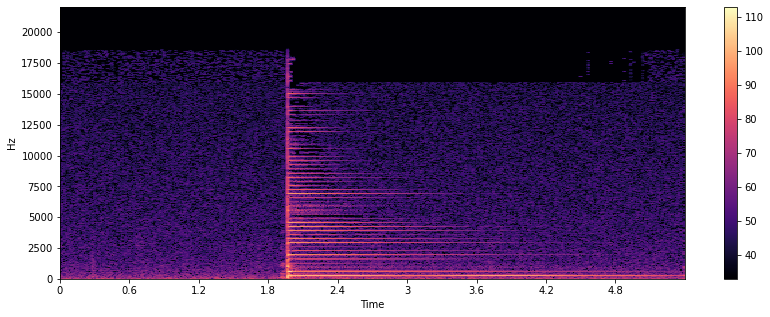

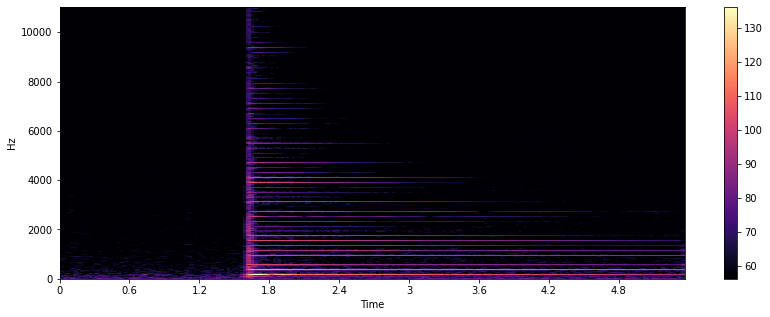

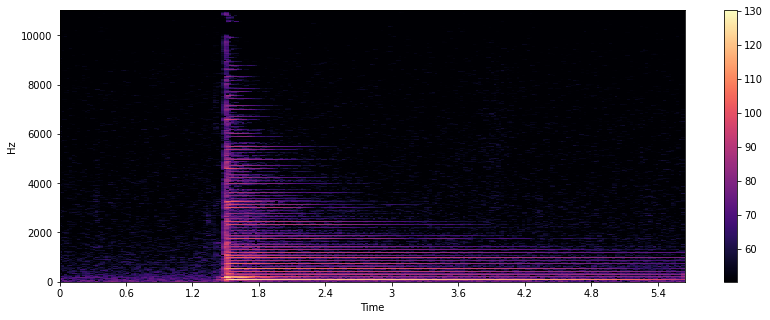

In [10]:
import librosa #Library to convert to energy (db)
import librosa.display #Represent intensity

#Conviersion to float
data_1=data_1.astype(np.float32)
data_2=data_2.astype(np.float32)
data_3=data_3.astype(np.float32)
#Do short-time fourier transform of the data
X_1 = librosa.stft(data_1)
X_2 = librosa.stft(data_2) 
X_3 = librosa.stft(data_3)
#We convert the data to db, as it is the standard metric for audio loudness.
Xdb_1 = librosa.amplitude_to_db(abs(X_1))
Xdb_2 = librosa.amplitude_to_db(abs(X_2))
Xdb_3 = librosa.amplitude_to_db(abs(X_3))
#Plot the 3 heatmaps
#Audio1
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_1, sr=sr_1, x_axis='time', y_axis='hz')
plt.colorbar()

#Audio2
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_2, sr=sr_2, x_axis='time', y_axis='hz')
plt.colorbar()

#Audio3
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_3, sr=sr_3, x_axis='time', y_axis='hz')
plt.colorbar()

We can convert the plot in the logarithmic scale to see clearly where the intensity of each audio is.

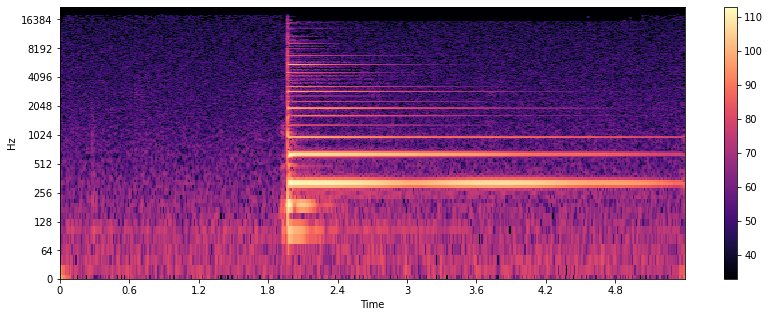

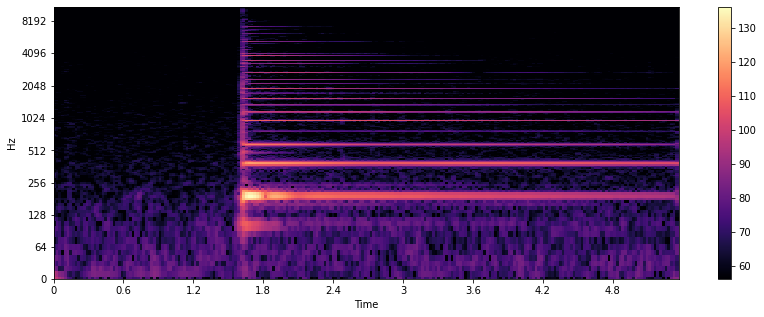

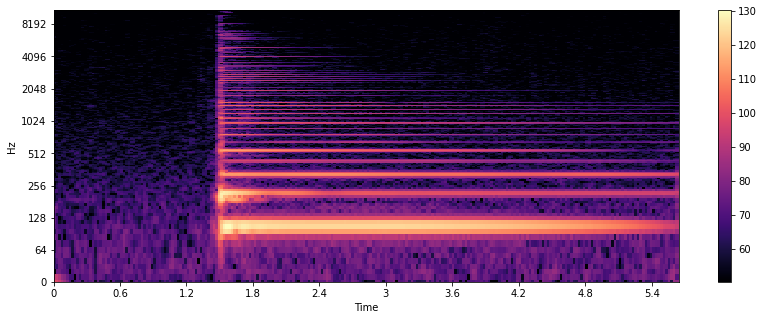

In [11]:
#Audio 1
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_1, sr=sr_1, x_axis='time', y_axis='log')
plt.colorbar()

#Audio 2
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_2, sr=sr_2, x_axis='time', y_axis='log')
plt.colorbar()

#Audio 3
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb_3, sr=sr_3, x_axis='time', y_axis='log')
plt.colorbar()

We can conclude that the intensities of each audio are fairly similar thanks to this short analysis. The main difference can be seen in the ranges of the frecuencies because the sample rate of the first one is double that the other two.

##Feature extraction
In this section, we will identify key features of each audio file.

###Spectral centroid
The spectral centroid indicates at which frequency the energy of a spectrum is centered upon (like the center of mass). To calculate it, we will get the bins by framing the spectral centroids and then normilize the means. [1][2]

In [12]:
spectral_centroids_1 = librosa.feature.spectral_centroid(data_1, sr=sr_1)[0]
spectral_centroids_2 = librosa.feature.spectral_centroid(data_2, sr=sr_2)[0]
spectral_centroids_3 = librosa.feature.spectral_centroid(data_3, sr=sr_3)[0]

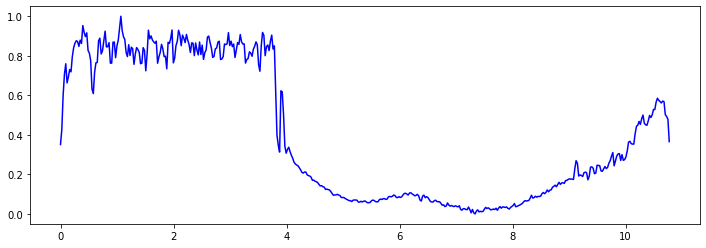

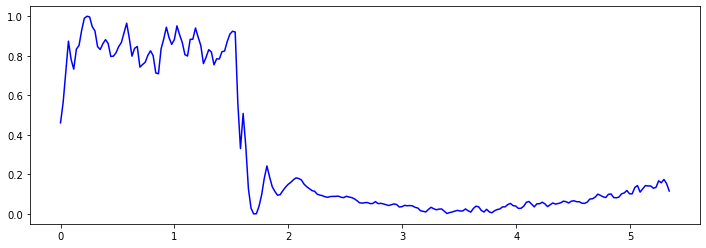

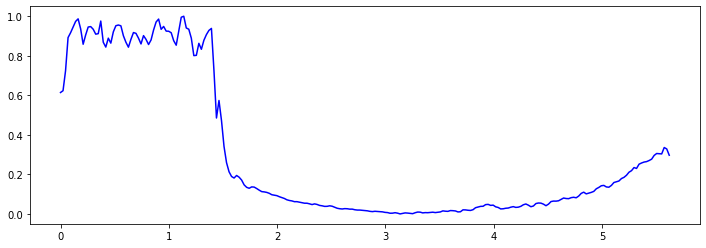

In [13]:
#Audio 1
plt.figure(figsize=(12, 4))
frames_1 = range(len(spectral_centroids_1))
t_1 = librosa.frames_to_time(frames_1)
plt.plot(t_1, normalize(spectral_centroids_1), color='b')

#Audio 2
plt.figure(figsize=(12, 4))
frames_2 = range(len(spectral_centroids_2))
t_2 = librosa.frames_to_time(frames_2)
plt.plot(t_2, normalize(spectral_centroids_2), color='b')

#Audio 3
plt.figure(figsize=(12, 4))
frames_3 = range(len(spectral_centroids_3))
t_3 = librosa.frames_to_time(frames_3)
plt.plot(t_3, normalize(spectral_centroids_3), color='b')

###Spectral Rolloff
It is a measure of the shape of the signal. It represents the frequency at which high frequencies decline to 0. [1][2]

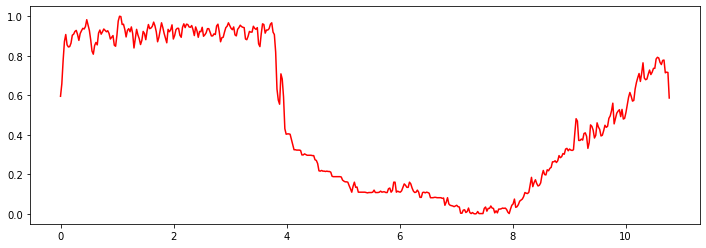

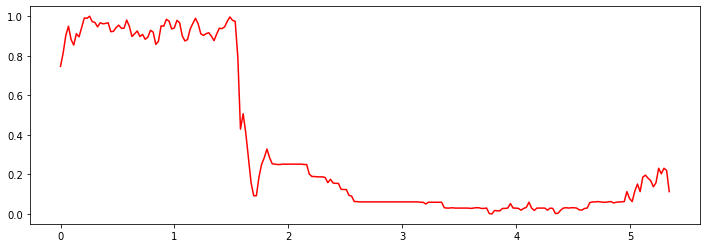

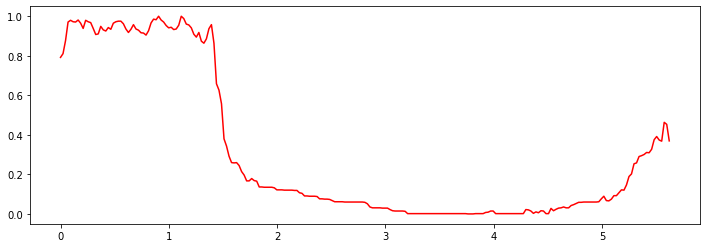

In [14]:
#Audio 1
spectral_rolloff_1 = librosa.feature.spectral_rolloff(data_1+0.01)[0]
plt.figure(figsize=(12, 4))
plt.plot(t_1, normalize(spectral_rolloff_1), color='r')

#Audiio 2
spectral_rolloff_2 = librosa.feature.spectral_rolloff(data_2+0.01)[0]
plt.figure(figsize=(12, 4))
plt.plot(t_2, normalize(spectral_rolloff_2), color='r')

#Audio 3
spectral_rolloff_3 = librosa.feature.spectral_rolloff(data_3+0.01)[0]
plt.figure(figsize=(12, 4))
plt.plot(t_3, normalize(spectral_rolloff_3), color='r')



###Mel-Frequency Cepstral Coefficients(MFCCs)
The Mel-Frequency Cepstral Coefficients (MFCCs) of a signal are a small set of features which concisely describe the overall shape of a spectral envelope. This feature is quite interesting because it is modelled around the human hearing ability. [1][2]

In [15]:
mfccs_1 = librosa.feature.mfcc(data_1)
mfccs_2 = librosa.feature.mfcc(data_2)
mfccs_3 = librosa.feature.mfcc(data_3)

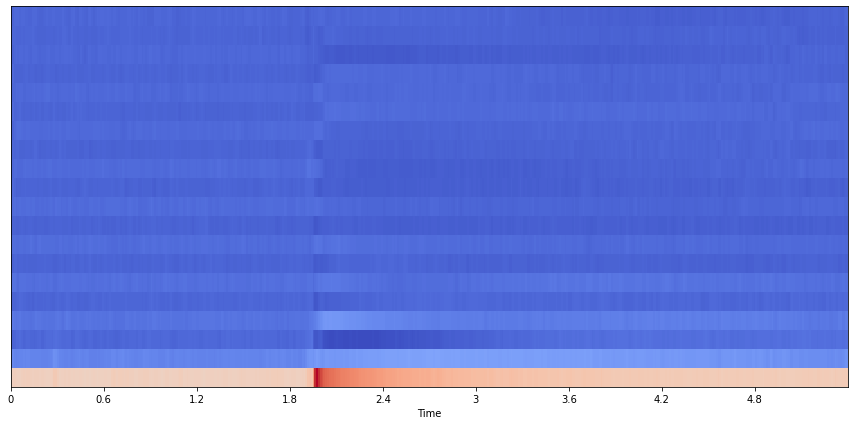

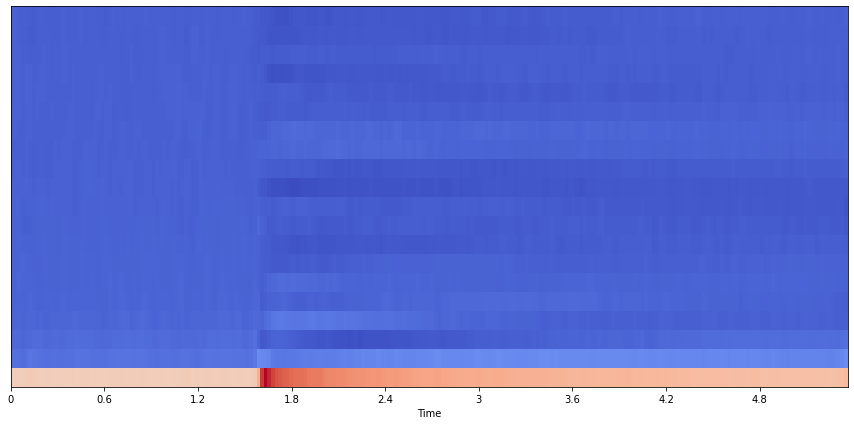

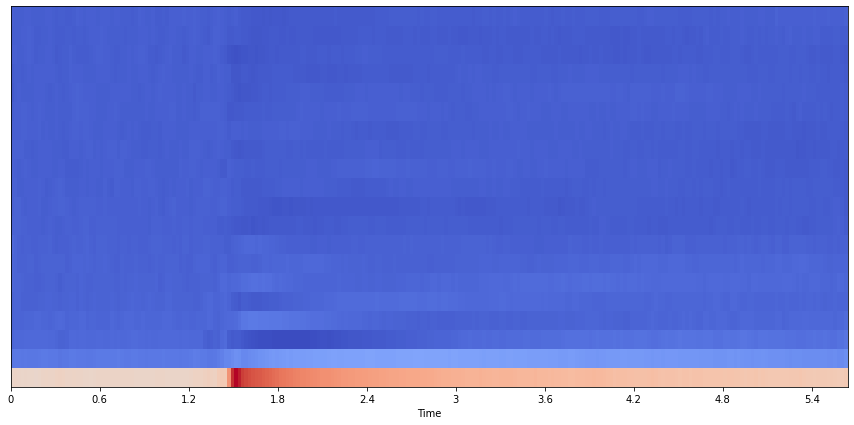

In [17]:
#Displaying  the MFCCs:
#Audio 1
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs_1, sr=sr_1, x_axis='time')

#Audio 2
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs_2, sr=sr_2, x_axis='time')

#Audio 3
plt.figure(figsize=(15, 7))
librosa.display.specshow(mfccs_3, sr=sr_3, x_axis='time')

###Chroma feature
This feature will be an appetizer of getting the right notes for each audio signal, because the chroma feature will indicate us how much energy of each pitch class, is present in the signal. [1][2]

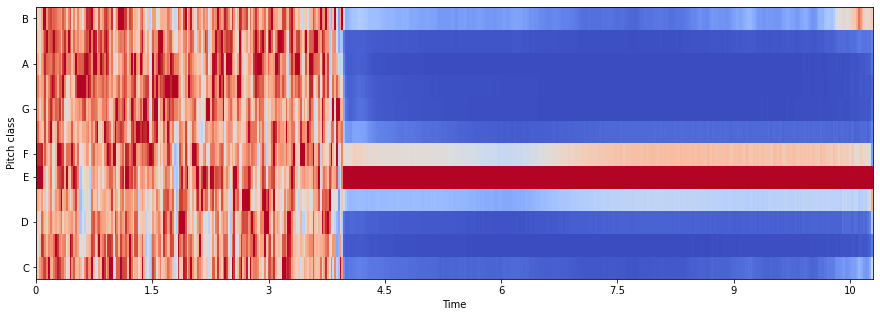

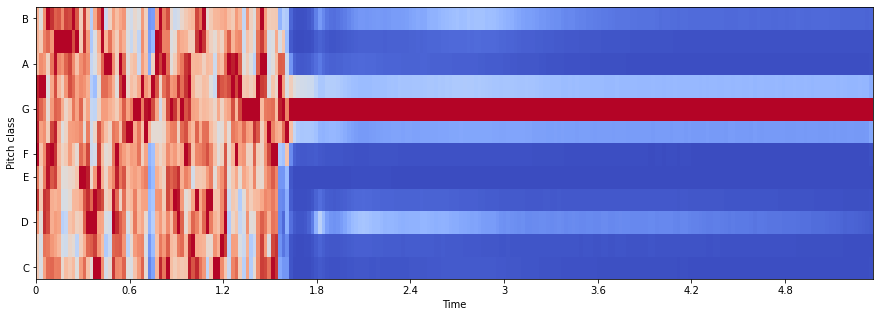

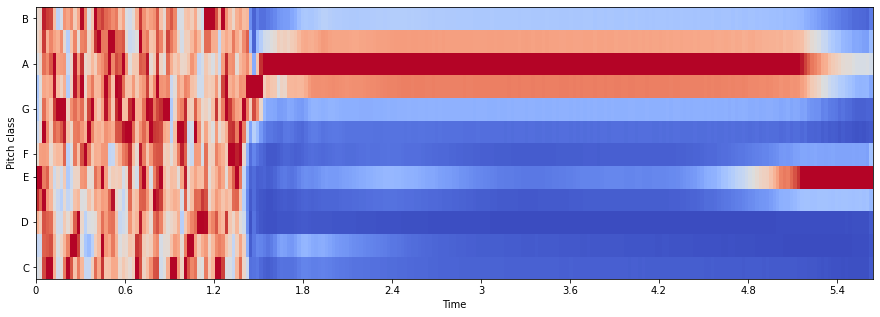

In [18]:
#Audio 1
chromagram_1 = librosa.feature.chroma_stft(data_1)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram_1, x_axis='time', y_axis='chroma', cmap='coolwarm')

#Audio 2
chromagram_2 = librosa.feature.chroma_stft(data_2)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram_2, x_axis='time', y_axis='chroma', cmap='coolwarm')

#Audio 3
chromagram_3 = librosa.feature.chroma_stft(data_3)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chromagram_3, x_axis='time', y_axis='chroma', cmap='coolwarm')

We can already predict that the first audio will be an E, the second a G, and the third one seems a little bit more tricky than the others

# REFERENCES
[1] [Audio analysis with Python](https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html)

[2] [A Tutorial on Spectral Feature Extraction for Audio Analysis](https://analyticsindiamag.com/a-tutorial-on-spectral-feature-extraction-for-audio-analytics/)

[3] [Hertz and Cent](https://www.dirksprojects.nl/index.php?Lan=english&Page=info/HertzAndCent.php)